In [1]:
from pathlib import Path
import pandas as pd
from datetime import datetime
import csv

import matplotlib
import matplotlib.pyplot as plt

import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2
import numpy as np

import random
random.seed(42)

%matplotlib inline

**Plan**
1. NaNs +
2. Customer outliers
3. *Column* in terms frequency and amount - outliers
4. How many goods of certain groups (of goods)
5. Descriptives (discount, good preferences, preferences of group of good, etc.)

**0. Read data**

In [2]:
data_dir = Path('data/prepared')
!ls {data_dir}

09_prepared.pkl.bz2  11_prepared.pkl.bz2  doc_lbe.pkl.bz2  outliers.pkl.bz2
10_prepared.pkl.bz2  card_lbe.pkl.bz2	  groups.csv


In [3]:
product_groups_file = data_dir / 'groups.csv'
september_file = data_dir / '09_prepared.pkl.bz2'
october_file = data_dir / '10_prepared.pkl.bz2'
november_file = data_dir / '11_prepared.pkl.bz2'
# merged = data_dir / 'merged.csv'

In [4]:
with bz2.open(september_file, 'rb') as f:
    df = pickle.load(f)
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271,1.0,108.00,False,1538855,1283228
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271,1.0,108.00,False,267307,8873113
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271,1.0,107.95,False,610220,12712899
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271,1.0,108.00,False,441497,21535283
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97,2.0,88.00,False,1065358,642341


In [5]:
# df.drop(['id_card', 'id_doc'], axis=1, inplace=True)

In [6]:
# with bz2.open(data_path / 'card_lbe.pkl.bz2', 'rb') as f:
#     card_lbe = pickle.load(f)
# card_lbe.head()

In [7]:
# with bz2.open(data_path / 'doc_lbe.pkl.bz2', 'rb') as f:
#     doc_lbe = pickle.load(f)
# doc_lbe.head()

In [8]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
columns = [s for s in 'date;id_doc;id_order;id_card;id_tov;id_kontr;quantity;sum;is_green'.split(';')]
print(columns)

['date', 'id_doc', 'id_order', 'id_card', 'id_tov', 'id_kontr', 'quantity', 'sum', 'is_green']


In [9]:
df.dtypes

date           datetime64[ns]
id_doc                 object
id_order                int64
id_card                object
id_tov                  int64
id_kontr                int64
quantity              float64
sum                   float64
is_green                 bool
id_card_int             int64
id_doc_int              int64
dtype: object

In [10]:
len(df)

42100858

**1. Handle null values** 

In [11]:
df.isnull().values.any()

False

In [12]:
# col_with_nulls = df.loc[:, df.isnull().any()].columns
# col_with_nulls

In [13]:
# df[df['id_kontr'].isnull()].head()

In [14]:
# # for now treat any null values as potential indicators of outliers: 
# # fill them with unrealistic values (other approach could be replacing nulls with the most frequent value)

# null_fill_value = -9999
# col = 'id_kontr'
# df[col][df[col].isnull()] = null_fill_value
   
# df[df['id_kontr'] == null_fill_value].head()

**2. Identify customer outliers**
 - Bought too much (quantity)
 - Bought too often

In [15]:
df['id_card'].nunique(), df['id_doc'].nunique()

(1358089, 7709739)

In [16]:
df

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271,1.0,108.00,False,1538855,1283228
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271,1.0,108.00,False,267307,8873113
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271,1.0,107.95,False,610220,12712899
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271,1.0,108.00,False,441497,21535283
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97,2.0,88.00,False,1065358,642341
...,...,...,...,...,...,...,...,...,...,...,...
42100853,2020-09-30 11:26:28,350DE9C7-F602-EB11-B444-005056A7539A,0,A465340,25292,17528,1.0,130.00,False,1739990,4850561
42100854,2020-09-30 08:12:39,6D7ACBFB-DB02-EB11-B444-005056A7539A,0,A698682,30740,19188,2.0,120.00,False,1761351,10015419
42100855,2020-09-30 09:54:24,F96D45E8-E902-EB11-B444-005056A7539A,0,7790662,30741,19188,1.0,73.00,False,1432778,22816791
42100856,2020-09-30 12:00:04,12067064-FB02-EB11-B444-005056A7539A,0,2751739,34835,15916,1.0,78.00,False,484390,1648929


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100858 entries, 0 to 42100857
Data columns (total 11 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   id_doc       object        
 2   id_order     int64         
 3   id_card      object        
 4   id_tov       int64         
 5   id_kontr     int64         
 6   quantity     float64       
 7   sum          float64       
 8   is_green     bool          
 9   id_card_int  int64         
 10  id_doc_int   int64         
dtypes: bool(1), datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 3.2+ GB


In [18]:
# ##df['id_card'] = df['id_card'].astype('int')  #not possible: letters present
# df['id_kontr'] = df['id_kontr'].astype('int')
# df['quantity'] = df['quantity'].str.replace(',', '.').astype('float')
# df['sum'] = df['sum'].str.replace(',', '.').astype('float')
# df['date'] = pd.to_datetime(df['date'])

In [19]:
df.describe()

,id_order,id_tov,id_kontr,quantity,sum,id_card_int,id_doc_int
count,4.210086e+07,4.210086e+07,4.210086e+07,4.210086e+07,4.210086e+07,4.210086e+07,4.210086e+07
mean,7.765869e+05,1.763064e+04,1.045977e+04,1.427065e+00,1.149112e+02,8.446032e+05,1.170384e+07
std,2.032896e+06,1.103226e+04,8.794764e+03,3.101411e+01,1.072201e+02,5.388947e+05,6.760102e+06
min,0.000000e+00,4.600000e+01,-9.999000e+03,-2.755000e+00,-1.022110e+03,0.000000e+00,2.000000e+00
25%,0.000000e+00,1.452600e+04,3.850000e+02,1.000000e+00,4.800000e+01,3.650470e+05,5.848724e+06
50%,0.000000e+00,1.943500e+04,1.358100e+04,1.000000e+00,8.900000e+01,8.150010e+05,1.170182e+07
75%,0.000000e+00,2.455800e+04,1.630400e+04,1.000000e+00,1.501100e+02,1.288708e+06,1.755596e+07
max,6.673056e+06,3.866000e+04,2.194300e+04,5.000000e+03,3.840000e+04,1.944074e+06,2.341787e+07


In [20]:
neg_quantity = df[df['quantity'] <= 0]
neg_quantity

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
76223,2020-09-01 19:48:39,FB34A539-74EC-EA11-B444-005056A7539A,5588920,0586045,15738,19687,0.0,0.79,False,116224,22979294
144688,2020-09-01 17:10:48,4089BF02-5DEC-EA11-B444-005056A7539A,0,A485529,28662,19687,0.0,0.89,False,1741530,5901464
1211336,2020-09-01 19:50:39,2FD6C495-74EC-EA11-B444-005056A7539A,0,5259037,23008,17616,0.0,0.51,False,974892,4375162
1649328,2020-09-02 22:07:29,40D624F8-4FED-EA11-B444-005056A7539A,0,0761743,731,17268,0.0,0.14,False,145090,5928667
2013148,2020-09-02 16:28:46,4D29BB5A-20ED-EA11-B444-005056A7539A,0,0988768,731,21309,0.0,0.18,False,183930,7056809
...,...,...,...,...,...,...,...,...,...,...,...
40844727,2020-09-30 20:07:33,24CECE9A-3F03-EB11-B444-005056A7539A,0,0139028,22911,17394,0.0,0.23,False,29462,3367001
40845729,2020-09-30 20:07:33,24CECE9A-3F03-EB11-B444-005056A7539A,0,0139028,37885,19438,0.0,0.38,False,29462,3367001
41157457,2020-09-30 17:58:33,CDA17091-2E03-EB11-B444-005056A7539A,0,3807306,22911,17394,0.0,0.46,False,670914,18810832
41705116,2020-09-30 13:05:17,0B27EEE3-0403-EB11-B444-005056A7539A,0,4176864,15817,15255,0.0,0.22,False,748972,1020540


In [21]:
neg_sum = df[df['sum'] < 0]
neg_sum

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
4206092,2020-09-04 09:10:21,827B9591-75EE-EA11-B444-005056A7539A,0,7009929,23074,19269,1.268,-470.43,False,1301664,11939194
4206102,2020-09-04 09:09:24,F6807973-75EE-EA11-B444-005056A7539A,0,7707981,23074,19269,1.268,-470.43,False,1419650,22549976
4210124,2020-09-04 08:37:00,49C21AF5-70EE-EA11-B444-005056A7539A,0,5554550,23074,19269,1.084,-402.16,False,1035577,6745380
4218019,2020-09-04 08:43:37,B681FEE3-71EE-EA11-B444-005056A7539A,0,0643258,23074,19269,0.001,-0.37,False,126995,16694740
4218021,2020-09-04 08:43:37,B681FEE3-71EE-EA11-B444-005056A7539A,0,0643258,23074,19269,2.375,-881.13,False,126995,16694740
...,...,...,...,...,...,...,...,...,...,...,...
5396780,2020-09-04 08:37:49,1CC214FB-70EE-EA11-B444-005056A7539A,0,4916790,23074,19269,1.236,-458.56,False,906517,2630312
5438901,2020-09-04 09:28:21,E6F17E03-78EE-EA11-B444-005056A7539A,0,5931979,23074,19269,0.572,-212.21,False,1102820,21125316
5450157,2020-09-04 09:21:17,CD1BCB2C-77EE-EA11-B444-005056A7539A,0,3290674,23074,19269,0.915,-339.47,False,574393,18763274
5450159,2020-09-04 09:21:17,CD1BCB2C-77EE-EA11-B444-005056A7539A,0,3290674,23074,19269,0.915,-339.47,False,574393,18763274


Negative values look strange... probably these are the outliers which are transactions between stores, or just noise. As there are quite few of them, let's just remove these samples.

In [22]:
shop_transactions = df[(df['sum'] < 0) | (df['quantity'] <= 0)]
shop_transactions

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
76223,2020-09-01 19:48:39,FB34A539-74EC-EA11-B444-005056A7539A,5588920,0586045,15738,19687,0.0,0.79,False,116224,22979294
144688,2020-09-01 17:10:48,4089BF02-5DEC-EA11-B444-005056A7539A,0,A485529,28662,19687,0.0,0.89,False,1741530,5901464
1211336,2020-09-01 19:50:39,2FD6C495-74EC-EA11-B444-005056A7539A,0,5259037,23008,17616,0.0,0.51,False,974892,4375162
1649328,2020-09-02 22:07:29,40D624F8-4FED-EA11-B444-005056A7539A,0,0761743,731,17268,0.0,0.14,False,145090,5928667
2013148,2020-09-02 16:28:46,4D29BB5A-20ED-EA11-B444-005056A7539A,0,0988768,731,21309,0.0,0.18,False,183930,7056809
...,...,...,...,...,...,...,...,...,...,...,...
40844727,2020-09-30 20:07:33,24CECE9A-3F03-EB11-B444-005056A7539A,0,0139028,22911,17394,0.0,0.23,False,29462,3367001
40845729,2020-09-30 20:07:33,24CECE9A-3F03-EB11-B444-005056A7539A,0,0139028,37885,19438,0.0,0.38,False,29462,3367001
41157457,2020-09-30 17:58:33,CDA17091-2E03-EB11-B444-005056A7539A,0,3807306,22911,17394,0.0,0.46,False,670914,18810832
41705116,2020-09-30 13:05:17,0B27EEE3-0403-EB11-B444-005056A7539A,0,4176864,15817,15255,0.0,0.22,False,748972,1020540


In [23]:
df.drop(df[df['quantity'] < 0].index, inplace=True)
df.drop(df[df['sum'] < 0].index, inplace=True)

In [24]:
df

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271,1.0,108.00,False,1538855,1283228
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271,1.0,108.00,False,267307,8873113
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271,1.0,107.95,False,610220,12712899
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271,1.0,108.00,False,441497,21535283
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97,2.0,88.00,False,1065358,642341
...,...,...,...,...,...,...,...,...,...,...,...
42100853,2020-09-30 11:26:28,350DE9C7-F602-EB11-B444-005056A7539A,0,A465340,25292,17528,1.0,130.00,False,1739990,4850561
42100854,2020-09-30 08:12:39,6D7ACBFB-DB02-EB11-B444-005056A7539A,0,A698682,30740,19188,2.0,120.00,False,1761351,10015419
42100855,2020-09-30 09:54:24,F96D45E8-E902-EB11-B444-005056A7539A,0,7790662,30741,19188,1.0,73.00,False,1432778,22816791
42100856,2020-09-30 12:00:04,12067064-FB02-EB11-B444-005056A7539A,0,2751739,34835,15916,1.0,78.00,False,484390,1648929


Now let's look at the quantity of goods a user buys on average. 

We can eliminate the samples where the quantity is too large (transactions between shops). And the reasoning why we look at the mean values for a user (not simply eliminate large values) is that the transactions between shops may also have small quantity but we shouldn't take them into account when considering a user preferences etc. Thus, large mean value for quantity should indicate it is a shop transaction id card.

In [25]:
quantity_user = df.groupby(['id_card'], as_index=False)['quantity'].mean()
quantity_user = quantity_user.rename(columns={'quantity': 'user_mean_quantity'})
df = df.merge(quantity_user, on='id_card')
quantity_user

,id_card,user_mean_quantity
0,0000000,1.142500
1,0000001,1.000000
2,0000003,1.333333
3,0000009,1.148765
4,0000015,1.081333
...,...,...
1358084,c539320,1.141143
1358085,c551708,1.523333
1358086,c633515,1.110969
1358087,c679536,1.031702


In [26]:
quantity_user.describe()

,user_mean_quantity
count,1.358089e+06
mean,1.403017e+00
std,1.189936e+01
min,3.400000e-02
25%,1.000000e+00
50%,1.053500e+00
75%,1.250000e+00
max,2.500500e+03


<AxesSubplot:>

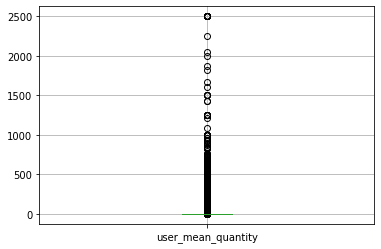

In [27]:
quantity_user.boxplot()

In [32]:
max_quantity_quantile = 0.997
potential_too_much_quantity = df[df['user_mean_quantity'] > df['user_mean_quantity'].quantile(max_quantity_quantile)]

quantity_threshold = potential_too_much_quantity['user_mean_quantity'].min()
print(quantity_threshold)
shop_transactions = shop_transactions.append(potential_too_much_quantity)

21.074119999999997


I personally rarely buy more than 21 items or 21 kg... I guess it may also be considered as outliers (transactions with large quantity).

There are quite a lot of such samples though, so let's remove them from here but store them in a separate dataframe *shop_transactions* (in case it is useful later)

In [33]:
shop_transactions

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,user_mean_quantity
76223,2020-09-01 19:48:39,FB34A539-74EC-EA11-B444-005056A7539A,5588920,0586045,15738,19687,0.000,0.79,False,116224,22979294,NaN
144688,2020-09-01 17:10:48,4089BF02-5DEC-EA11-B444-005056A7539A,0,A485529,28662,19687,0.000,0.89,False,1741530,5901464,NaN
1211336,2020-09-01 19:50:39,2FD6C495-74EC-EA11-B444-005056A7539A,0,5259037,23008,17616,0.000,0.51,False,974892,4375162,NaN
1649328,2020-09-02 22:07:29,40D624F8-4FED-EA11-B444-005056A7539A,0,0761743,731,17268,0.000,0.14,False,145090,5928667,NaN
2013148,2020-09-02 16:28:46,4D29BB5A-20ED-EA11-B444-005056A7539A,0,0988768,731,21309,0.000,0.18,False,183930,7056809,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
42091310,2020-09-30 09:29:06,0B649B87-E602-EB11-B444-005056A7539A,0,6738849,731,17268,0.905,79.64,False,1248684,1042156,286.435
42091311,2020-09-30 09:29:06,0B649B87-E602-EB11-B444-005056A7539A,0,6738849,1113,-9999,2000.000,0.00,False,1248684,1042156,286.435
42091312,2020-09-30 09:29:06,0B649B87-E602-EB11-B444-005056A7539A,0,6738849,15738,17616,0.760,149.72,False,1248684,1042156,286.435
42091313,2020-09-30 09:29:06,0B649B87-E602-EB11-B444-005056A7539A,0,6738849,15917,16612,0.680,87.04,False,1248684,1042156,286.435


In [34]:
df.drop(df[df['user_mean_quantity'] > quantity_threshold].index, inplace=True)

In [35]:
quantity_bill = df.groupby(['id_doc'], as_index=False)['quantity'].mean()
quantity_bill = quantity_bill.rename(columns={'quantity': 'doc_mean_quantity'})
df = df.merge(quantity_bill, on='id_doc')
quantity_bill

,id_doc,doc_mean_quantity
0,00000230-16FC-EA11-B444-005056A7539A,1.500000
1,00000292-91FE-EA11-B444-005056A7539A,1.117647
2,00000450-F1FC-EA11-B444-005056A7539A,1.000000
3,00000A30-E700-EB11-B444-005056A7539A,1.000000
4,00000C88-A3F6-EA11-B444-005056A7539A,1.033857
...,...,...
7679161,FFFFFA98-0AFC-EA11-B444-005056A7539A,1.000000
7679162,FFFFFBDD-1FF5-EA11-B444-005056A7539A,1.000000
7679163,FFFFFE9E-DAEC-EA11-B444-005056A7539A,1.800000
7679164,FFFFFEBE-FE09-41C5-A140-507AC54850D7,1.673222


In [36]:
quantity_bill.describe()

,doc_mean_quantity
count,7.679166e+06
mean,1.231915e+00
std,4.566324e+00
min,0.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.250000e+00
max,2.500500e+03


<AxesSubplot:>

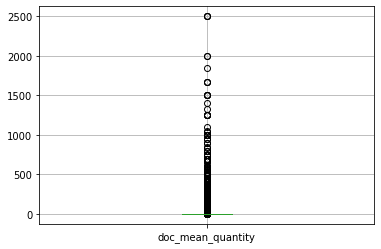

In [37]:
quantity_bill.boxplot()

In [46]:
max_doc_quantity_quantile = 0.9998
potential_too_much_quantity = df[df['doc_mean_quantity'] > df['doc_mean_quantity'].quantile(max_doc_quantity_quantile)]

doc_quantity_threshold = potential_too_much_quantity['doc_mean_quantity'].min()
print(doc_quantity_threshold)

shop_transactions = shop_transactions.append(potential_too_much_quantity)

18.0


In [47]:
df.drop(df[df['doc_mean_quantity'] > doc_quantity_threshold].index, inplace=True)

In [48]:
df

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,user_mean_quantity,doc_mean_quantity
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271,1.000,108.00,False,1538855,1283228,0.984667,0.931
1,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,647,-9999,1.000,5.00,False,1538855,1283228,0.984667,0.931
2,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,15044,17441,2.650,71.55,False,1538855,1283228,0.984667,0.931
3,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,18257,15829,0.406,44.66,False,1538855,1283228,0.984667,0.931
4,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,22920,16205,1.000,318.00,False,1538855,1283228,0.984667,0.931
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41974668,2020-09-30 09:37:16,F3CD288E-E702-EB11-B444-005056A7539A,0,3189952,34835,15916,1.000,78.00,False,557627,22302533,0.780000,0.780
41974669,2020-09-30 16:09:58,C150BA5C-1E03-EB11-B444-005056A7539A,0,C526660,16319,102,1.000,52.00,False,1871655,17683799,1.000000,1.000
41974670,2020-09-30 12:48:53,43CF9336-0203-EB11-B444-005056A7539A,0,7790662,22639,12970,1.000,188.00,False,1432778,6200411,1.000000,1.000
41974671,2020-09-30 09:54:24,F96D45E8-E902-EB11-B444-005056A7539A,0,7790662,30741,19188,1.000,73.00,False,1432778,22816791,1.000000,1.000


In [49]:
df.describe()

,id_order,id_tov,id_kontr,quantity,sum,id_card_int,id_doc_int,user_mean_quantity,doc_mean_quantity
count,4.196638e+07,4.196638e+07,4.196638e+07,4.196638e+07,4.196638e+07,4.196638e+07,4.196638e+07,4.196638e+07,4.196638e+07
mean,7.778325e+05,1.763116e+04,1.045965e+04,1.166921e+00,1.149443e+02,8.445707e+05,1.170380e+07,1.191966e+00,1.166921e+00
std,2.034279e+06,1.103138e+04,8.793696e+03,8.485783e-01,1.070363e+02,5.389248e+05,6.760055e+06,5.942443e-01,4.350260e-01
min,0.000000e+00,4.600000e+01,-9.999000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.400000e-02,0.000000e+00
25%,0.000000e+00,1.452600e+04,3.850000e+02,1.000000e+00,4.800000e+01,3.649530e+05,5.848770e+06,1.005200e+00,9.872000e-01
50%,0.000000e+00,1.943500e+04,1.358100e+04,1.000000e+00,8.900000e+01,8.149360e+05,1.170194e+07,1.112942e+00,1.048960e+00
75%,0.000000e+00,2.455800e+04,1.630400e+04,1.000000e+00,1.503700e+02,1.288665e+06,1.755577e+07,1.259847e+00,1.272727e+00
max,6.673056e+06,3.866000e+04,2.194300e+04,5.000000e+02,3.840000e+04,1.944074e+06,2.341787e+07,2.107412e+01,1.800000e+01


In [50]:
df[df.quantity > quantity_threshold]

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,user_mean_quantity,doc_mean_quantity
15990,2020-09-08 21:42:44,ABD8F5CD-04F2-EA11-B444-005056A7539A,0,0869878,1113,-9999,100.0,0.0,False,163739,15720970,1.842923,13.375000
229459,2020-09-18 16:43:22,C06A8E37-B5F9-EA11-B444-005056A7539A,0,6317441,23209,16887,25.0,900.0,False,1170400,17601815,1.535202,2.458129
238726,2020-09-01 21:22:46,73D4665A-80EC-EA11-B444-005056A7539A,0,5188648,23209,16887,29.0,1044.0,False,961580,10597171,1.986212,15.000000
249467,2020-09-26 14:31:45,DE5ECA39-ECFF-EA11-B444-005056A7539A,0,5887055,25150,17639,25.0,550.0,False,1093860,20341297,1.765458,13.000000
257575,2020-09-21 18:53:54,2EDB56E6-23FC-EA11-B444-005056A7539A,0,0509972,20497,14557,36.0,720.0,False,101342,4285282,1.524260,13.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41829400,2020-09-29 23:02:00,57530DBE-8E02-EB11-B444-005056A7539A,0,4079924,16842,12853,24.0,456.0,False,727152,7986208,6.200000,6.200000
41920430,2020-09-30 08:42:42,43EADBF6-DF02-EB11-B444-005056A7539A,6618085,4211919,12210,122,25.0,2150.0,False,756601,6210316,13.250000,13.250000
41920431,2020-09-30 08:42:42,43EADBF6-DF02-EB11-B444-005056A7539A,6618085,4211919,20494,14557,25.0,575.0,False,756601,6210316,13.250000,13.250000
41935434,2020-09-30 15:32:35,A53806AF-1903-EB11-B444-005056A7539A,0,0206107,14472,14211,27.0,1539.0,False,43338,15115062,11.800000,11.800000


In [51]:
shop_transactions = shop_transactions.append(df[df['quantity'] > quantity_threshold])
df.drop(df[df['quantity'] > quantity_threshold].index, inplace=True)

In [52]:
df.describe()

,id_order,id_tov,id_kontr,quantity,sum,id_card_int,id_doc_int,user_mean_quantity,doc_mean_quantity
count,4.196435e+07,4.196435e+07,4.196435e+07,4.196435e+07,4.196435e+07,4.196435e+07,4.196435e+07,4.196435e+07,4.196435e+07
mean,7.777806e+05,1.763114e+04,1.045980e+04,1.165324e+00,1.149117e+02,8.445742e+05,1.170382e+07,1.191873e+00,1.166571e+00
std,2.034220e+06,1.103149e+04,8.793551e+03,7.899503e-01,1.068491e+02,5.389242e+05,6.760054e+06,5.937848e-01,4.310071e-01
min,0.000000e+00,4.600000e+01,-9.999000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.400000e-02,0.000000e+00
25%,0.000000e+00,1.452600e+04,3.850000e+02,1.000000e+00,4.800000e+01,3.649550e+05,5.848772e+06,1.005200e+00,9.871818e-01
50%,0.000000e+00,1.943500e+04,1.358100e+04,1.000000e+00,8.900000e+01,8.149400e+05,1.170195e+07,1.112931e+00,1.048923e+00
75%,0.000000e+00,2.455800e+04,1.630400e+04,1.000000e+00,1.503300e+02,1.288679e+06,1.755578e+07,1.259796e+00,1.272727e+00
max,6.673056e+06,3.866000e+04,2.194300e+04,2.100000e+01,3.840000e+04,1.944074e+06,2.341787e+07,2.107412e+01,1.800000e+01


In [53]:
outliers = shop_transactions[['id_doc_int']]

with bz2.open(data_dir / 'outliers.pkl.bz2', 'wb') as f:
    pickle.dump(outliers, f, protocol=4)

In [54]:
with bz2.open(data_dir / 'outliers.pkl.bz2', 'rb') as f:
    quantity_outliers = pickle.load(f)
quantity_outliers

,id_doc_int
76223,22979294
144688,5901464
1211336,4375162
1649328,5928667
2013148,7056809
...,...
41829400,7986208
41920430,6210316
41920431,6210316
41935434,15115062


**Now let's check the frequency of purchases:**

In [55]:
df['day'] = df['date'].dt.date
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int,user_mean_quantity,doc_mean_quantity,day
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271,1.000,108.00,False,1538855,1283228,0.984667,0.931,2020-09-01
1,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,647,-9999,1.000,5.00,False,1538855,1283228,0.984667,0.931,2020-09-01
2,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,15044,17441,2.650,71.55,False,1538855,1283228,0.984667,0.931,2020-09-01
3,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,18257,15829,0.406,44.66,False,1538855,1283228,0.984667,0.931,2020-09-01
4,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,22920,16205,1.000,318.00,False,1538855,1283228,0.984667,0.931,2020-09-01


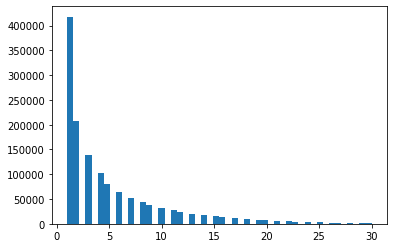

In [56]:
card_unique_days = df.groupby(['id_card_int'])['day'].nunique()
card_unique_days = card_unique_days.sort_values(ascending=False)
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins, rectangles = ax.hist(card_unique_days, 50)
fig.canvas.draw()
plt.show()

<AxesSubplot:>

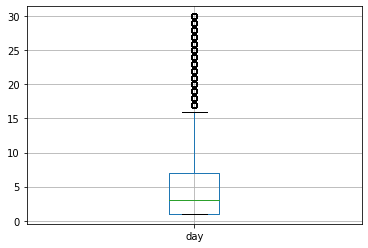

In [57]:
pd.DataFrame(card_unique_days).boxplot() 

In [ ]:
#
day_user = df.groupby(['id_card'], as_index=False)['day'].nunique()
day_user = day_user.rename(columns={'day': 'user_n_days'})
df = df.merge(day_user, on='id_card')
day_user

In [ ]:

day_user.describe()


In [ ]:
day_user.boxplot()


In [ ]:

max_day_user_quantile = 0.997
shop_transactions = shop_transactions.append(df[df['user_n_days'] > df['user_n_days'].quantile(max_day_user_quantile)])
day_user_threshold = shop_transactions['user_n_days'].min()
day_user_threshold


In [ ]:

shop_transactions

# df.drop(df[df['user_n_days'] > day_user_threshold].index, inplace=True)

In [ ]:
outliers = shop_transactions[['id_doc_int']]

with bz2.open(data_dir / 'outliers.pkl.bz2', 'wb') as f:
    pickle.dump(outliers, f, protocol=4)